# Regression (Pytorch basics)

## Setup

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

In [2]:
# tensors broadcasting

x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)

print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}\n")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])

x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [3]:
# simple regression data

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # out
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # in

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_un = 0.1 * t_u # normalized

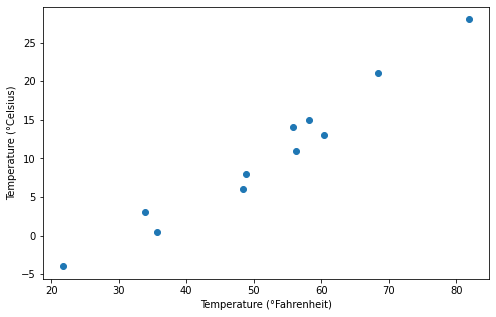

In [4]:
fig = plt.figure(figsize=(8, 5))
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [5]:
# model and loss function

def model(t_u, w, b):
    return w * t_u + b
    
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

## Autograd

In [6]:
# accumulates the gradient relative to params for every step involving them
# in a forward graph
params = torch.tensor([0.0, 1.0], requires_grad=True) 

In [7]:
# example

# grad is empty now
print(params.grad is None)

# calculate loss
loss = loss_fn(model(t_u, *params), t_c)

# calculate gradient for params based on loss
loss.backward()

print(params.grad)

# since it's accumulated and not assigned each time, 
# it must be set to zero afterwards!
if params.grad is not None:
    params.grad.zero_()

True
tensor([-1260.7000,   -19.0000])


## Optimizers

In [8]:
# optimizers do the update according to different strategies
# like plain GD, SGD, ore using adaptive learning rates (Adam)
[op for op in dir(optim) if op[0].isupper()]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam']

In [9]:
# example

# setup
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

# single iteration
t_p = model(t_un, *params) # calculate model predictions for current params
loss = loss_fn(t_p, t_c) # calculate loss

optimizer.zero_grad() # set gradient to zero
loss.backward() # calculate new gradient based on loss
optimizer.step() # update params

print(params)

tensor([1.0100, 0.0100], requires_grad=True)


## Training loops

### basic

In [10]:
# simple training loop

def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c) 
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {loss:.4f}')
            
    return params

In [11]:
# training

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u,  
    t_c = t_c)

Epoch 500, Loss 7.6129
Epoch 1000, Loss 3.0867
Epoch 1500, Loss 2.9286
Epoch 2000, Loss 2.9276


tensor([  0.5367, -17.3021], requires_grad=True)

### with validation set

In [12]:
# always use a validation set!

# train and valid indices
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

# data splitting
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [13]:
# training loop

# we calculate val preds and loss with torch.no_grad()
# in order to save time: we avoid saving the computation graph
# since we only use backpropagation on train_loss

def training_loop(n_epochs, optimizer, params,
                  train_t_u, val_t_u, train_t_c, val_t_c):
    
    for epoch in range(1, n_epochs + 1):

        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    return params

In [14]:
# training

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un, 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 93.9443, Validation loss 19.2545
Epoch 2, Training loss 43.2299, Validation loss 0.7752
Epoch 3, Training loss 35.5362, Validation loss 4.8714
Epoch 500, Training loss 7.1039, Validation loss 5.2108
Epoch 1000, Training loss 3.5098, Validation loss 3.8908
Epoch 1500, Training loss 3.0399, Validation loss 3.5031
Epoch 2000, Training loss 2.9784, Validation loss 3.3746
Epoch 2500, Training loss 2.9704, Validation loss 3.3296
Epoch 3000, Training loss 2.9693, Validation loss 3.3136


tensor([  5.3838, -17.0660], requires_grad=True)

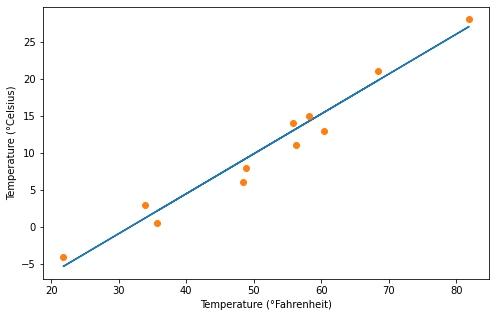

In [15]:
# visualize predictions

t_p = model(t_un, *params)

fig = plt.figure(figsize=(8,5))
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
#plt.plot(t_u.numpy(), t_p.detach().numpy(), 'o')
plt.plot(t_u.numpy(), t_c.numpy(), 'o') 

## Now use the torch.nn module!

In [16]:
# preprare data

# put data into tensors
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # B x Nin
t_u = torch.tensor(t_u).unsqueeze(1)
print(f'Input shape: {t_u.shape}')

# train and validation indices
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# data splitting
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

Input shape: torch.Size([11, 1])


In [17]:
# define model
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [18]:
# print parameters
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
# training loop

def training_loop(n_epochs, model, loss_fn, optimizer,
                  train_x, train_y, val_x, val_y):
    
    for epoch in range(1, n_epochs + 1):

        train_pred = model(train_x)
        train_loss = loss_fn(train_pred, train_y)

        with torch.no_grad():
            val_pred = model(val_x)
            val_loss = loss_fn(val_pred, val_y)
            assert val_loss.requires_grad == False
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 250 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

In [20]:
# training
training_loop(
    n_epochs = 3000, 
    model = seq_model, # use nn model
    loss_fn = nn.MSELoss(), # use nn loss funtion
    optimizer = optim.SGD(seq_model.parameters(), lr=1e-3),
    train_x = t_un_train, 
    train_y = t_c_train,
    val_x = t_un_val,
    val_y = t_c_val)

Epoch 1, Training loss 216.6446, Validation loss 69.4006
Epoch 2, Training loss 209.2095, Validation loss 66.9960
Epoch 3, Training loss 202.1111, Validation loss 64.7877
Epoch 250, Training loss 37.9672, Validation loss 36.6048
Epoch 500, Training loss 12.5236, Validation loss 3.7477
Epoch 750, Training loss 6.0512, Validation loss 3.7762
Epoch 1000, Training loss 4.5214, Validation loss 4.7633
Epoch 1250, Training loss 7.5940, Validation loss 2.7156
Epoch 1500, Training loss 5.9861, Validation loss 2.2367
Epoch 1750, Training loss 5.3972, Validation loss 1.5552
Epoch 2000, Training loss 4.9023, Validation loss 0.9689
Epoch 2250, Training loss 4.3720, Validation loss 0.5543
Epoch 2500, Training loss 3.8557, Validation loss 0.3292
Epoch 2750, Training loss 3.4284, Validation loss 0.2463
Epoch 3000, Training loss 3.1031, Validation loss 0.2510


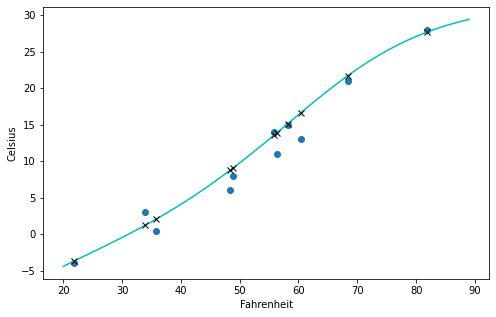

In [21]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(figsize=(8,5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')